In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import nutpie

print(f"Running on PyMC v{pm.__version__}")

# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Running on PyMC v5.20.0


In [2]:
# set the genuine model constants
sigma_true = 1
alpha_true = [1, 1.5, 2.5]

# number of fake data points
N = 200
X1 = np.random.randn(N)
X2 = np.random.randn(N) * 0.2

# simulate epsilon as N(0, sigma_true**2)
epsilon = rng.normal(size=N) * sigma_true
Y = alpha_true[0] + alpha_true[1] * X1 + alpha_true[2] * X2 + epsilon

basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10, shape=3)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha[0] + alpha[1] * X1 + alpha[2] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)


In [3]:
compiled_model = nutpie.compile_pymc_model(basic_model)

/home/jake/miniforge3/envs/pymc_env/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/home/jake/miniforge3/envs/pymc_env/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


In [4]:
trace_pymc = nutpie.sample(compiled_model,draws=2000, chains=4)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2300,0,0.98,3
,2300,0,1.03,3
,2300,0,0.96,3
,2300,0,1.01,3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.15,0.07,1.02,1.29,0.0,0.0,12547.58,6291.47,1.0
alpha[1],1.59,0.08,1.44,1.73,0.0,0.0,12535.40,5430.28,1.0
alpha[2],2.26,0.38,1.53,2.96,0.0,0.0,13638.49,6261.32,1.0
sigma_log__,0.04,0.05,-0.05,0.14,0.0,0.0,12366.21,6697.88,1.0
sigma,1.04,0.05,0.95,1.15,0.0,0.0,12366.21,6697.88,1.0


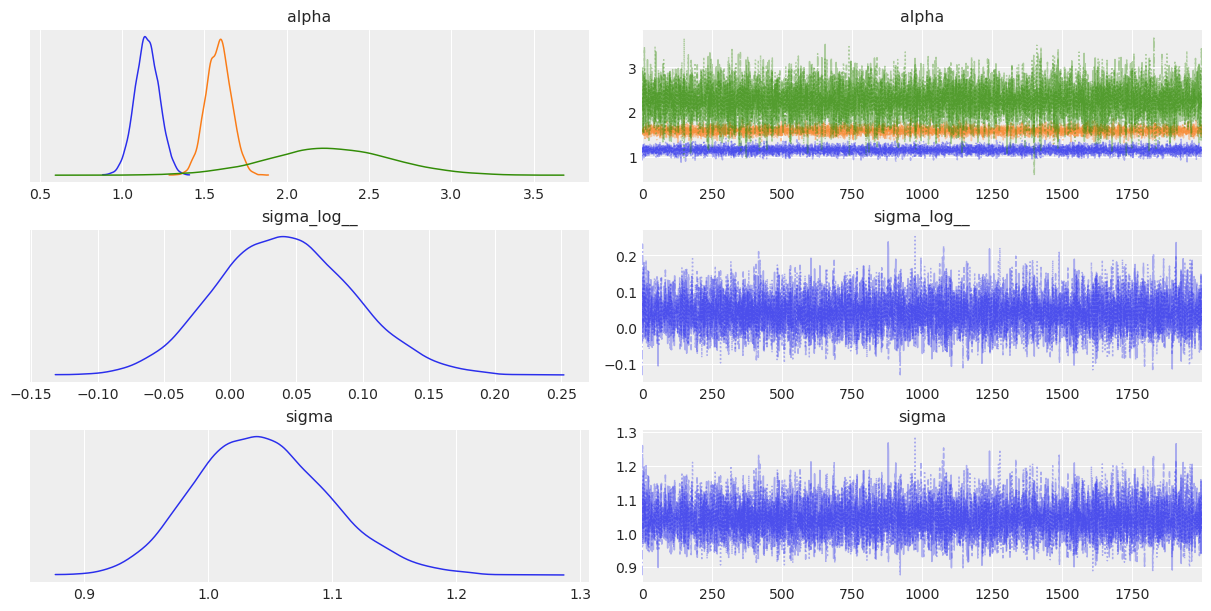

In [5]:
az.plot_trace(trace_pymc, combined=True)
az.summary(trace_pymc, round_to=2)


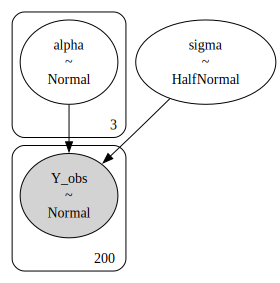

In [6]:
pm.model_to_graphviz(basic_model)

## Posterior Predictive

In [7]:
with basic_model:
    pp = pm.sample_posterior_predictive(trace_pymc)

Sampling: [Y_obs]


Output()

<Axes: xlabel='Y_obs'>

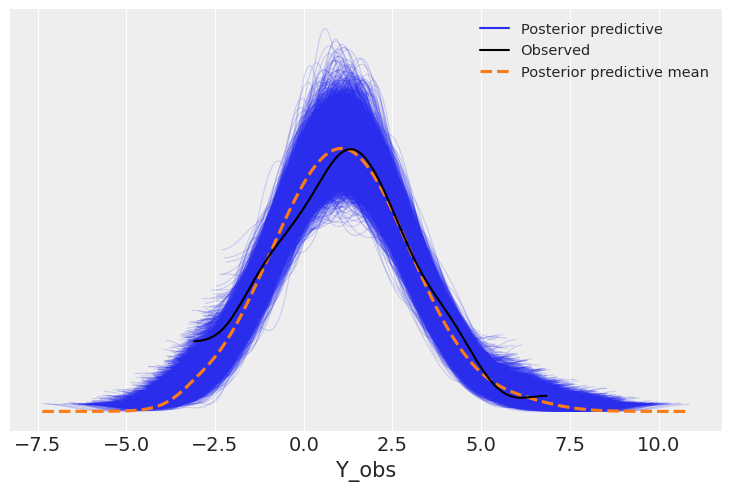

In [8]:
az.plot_ppc(pp)

In [9]:
# good to know
# pp['observed_data']['Y_obs'] == Y
# Gives True

<Axes: >

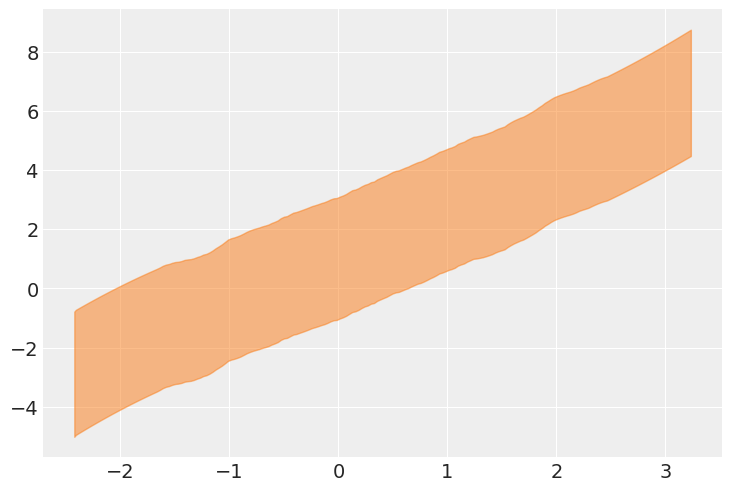

In [10]:
az.plot_hdi(X1, pp['posterior_predictive']['Y_obs'],hdi_prob=0.95)

### TODO

Read the pymc docs on [posterior predictive](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html#prediction).

Another guide on [posterior prediction](https://www.pymc-labs.com/blog-posts/out-of-model-predictions-with-pymc/)
that was mentioned in
[this forum](https://discourse.pymc.io/t/model-compilation-avoidance-when-reusing-a-model/13863).